# Modelado de Intercambio Aleatorio de Activos (RAE) 

En este trabajo se realizan simulaciones RAE. Se emplearon los modelos de intercambio cinético en [Dragulescu & Yakovenko (2000)](https://doi.org/10.1007/s100510070114)

## Sistema económico cerrado con conservación de dinero

### Descripción del modelo

Los agentes económicos interaccionan a pares mediante transacciones monetarias. Solo se puede recibir o dar dinero en las transacciones.

Sean $i$ ("perdedor") y $j$ ("ganador") un par de agentes económicos que interaccionan. Sean $m$ y $m'$ la cantidad de dinero que posee un agente, antes y después de la transacción, la cual se da según

$$
m_i \longrightarrow m'_i = m_i - \Delta m \\
m_j \longrightarrow m'_j = m_j + \Delta m
$$

donde $\Delta m$ es el dinero que el "perdedor" transfirió al "ganador" después de la transacción.

Suposiciones y restricciones:

* El dinero se conserva, global y localmente, $m_i + m_j = m'_i + m'_j$
* El balance de los ganadores no puede ser negativo, $m_i \ge 0 \forall i$
* Una transacción se da solamente cuando el agente "perdedor" tiene el suficiente dinero para pagar, $m_i \ge \Delta m$
* No hay crédito ni deuda

La mecánica estadística predice que el sistema económico alcanzará la distribución estacionaria de Boltzmann-Gibbs,
$$
P\left( m \right) = \frac{1}{T} \exp \left(-m/T \right)
$$

donde
$$
T = \left\langle m \right\rangle = \frac{M}{N}
$$

es la "Temperatura de dinero", igual a la cantidad promedio de dinero $\left\langle m \right\rangle$. $M$ es la cantidad de dinero total en el sistema, y $N$ el número de agentes. 

### Cómo se realizan las simulaciones

Los pasos para realizar una simulación son los siguientes:
* Inicialmente todos los agentes tienen la misma cantidad de dinero.
* Se elige un par ($i,j$) de agentes al azar, y se realiza la transacción, es decir, se transfiere la cantidad $\Delta m$.
* Se repite el paso anterior muchas veces.

En este trabajo se realizan simulaciones con cada una de las siguientes reglas de intercambio:
* Regla 1: Intercambio de una pequeña cantidad constante, $\Delta m = 1$.
* Regla 2: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del par, $\Delta m = \nu \left( m_i + m_j \right)/2$
* Regla 3: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del sistema,  $\Delta m = \nu T$

Observese que estas reglas tienen simetría de inversión temporal, ya que son invariantes ante una permutación de los índices $i$ y $j$.

### Simulaciones

Los parámetros para las simulaciones son: $N = 5 \times 10^{5}$ y $M = 5 \times 10^{6}$. Por lo tanto, al principio de las simulaciones, los agentes contarán con la misma cantidad de dinero $\left\langle m \right\rangle = \frac{M}{N} = 10$.

In [1]:
# Parámetros
Nexp = 5
N = int(5*(10**Nexp)) # número de agentes

Mexp = 6
M = 5*(10**Mexp) # cantidad total de dinero en el sistema

T = M/N # temperatura de dinero

Reglas de intercambio:

In [2]:
# reglas de intercambio
exchange_rules = ['small_constant', 'random_pair_average', 'random_system_average']

In [3]:
from economic_agent import Agent_BDY
from random import randint
import matplotlib.pyplot as plt
import numpy as np

(Nota: en la literatura RAE, los modelos de intercambio cinético con reglas de intercambio que tienen simetría de inversión temporal son también conocidos como **modelos de distribución de riqueza de Bennati-Dragulescu-Yakovenko** o BDY. Vea [esta referencia](https://doi.org/10.1103/RevModPhys.81.1703))

In [4]:
ex_order = 3 # Regla
exchange_rule = exchange_rules[ex_order - 1]

texp = 6
t_steps = int(4*(10**texp)) # Pasos de tiempo para la simulación

In [5]:
# Se crea a los agentes
agents_list = [Agent_BDY(money=T) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index], transaction_type=exchange_rule, system_avg=T)

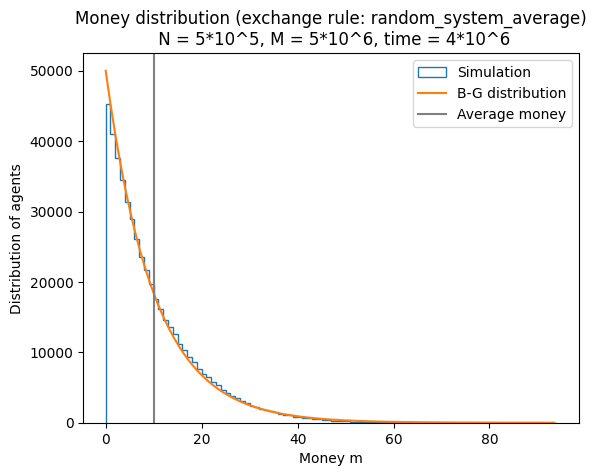

In [6]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.axvline(x=T, color = 'gray', label='Average money')
plt.title(f"Money distribution (exchange rule: {exchange_rule})\n N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

En las simulaciones observamos que una distribución inicial estrecha, en la que todos los agentes tienen la misma cantidad de dinero, es inestable y evoluciona con el tiempo hacia una distribución amplia y sesgada, en la que muchos agentes tienen saldos monetarios bajos y pocos agentes tienen saldos monetarios altos. Finalmente, la distribución de dinero alcanza el equilibrio estadístico en la forma exponencial (la distribución de Boltzmann-Gibbs), de acuerdo con los principios generales de la física estadística y el principio de máxima entropía. 

Sin embargo, si una regla para transferencias de dinero no tiene simetría de inversión temporal , se pueden obtener otras distribuciones.

## Sistema económico cerrado con conservación de dinero 2.0: se rompe la simetría de inversión temporal

### Modelo de intercambio aleatorio multiplicativo: Simulaciones

En este modelo de intercambio, la regla de transferencia es $\Delta m = \alpha m_i$, es decir, el intercambio es proporcional al saldo monetario del agente. En dicha regla se rompe la simetría de inversión temporal, por lo que el sistema puede tener una distribución estacionaria diferente a la de Boltzmann-Gibbs, o no tener ninguna distribución estacionaria.

Los parámetros para las simulaciones serán: $N = 5 \times 10^{5}$ y $M = 5 \times 10^{6}$. Por lo tanto, al principio de las simulaciones, los agentes contarán con la misma cantidad de dinero $\left\langle m \right\rangle = \frac{M}{N} = 10$.

Primero realizamos una simulación de intercambio aleatorio multiplicativo con $\alpha = 1/3$,

In [7]:
from economic_agent import Agent_multiplicative
from random import randint
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Parámetros
Nexp = 5
N = int(5*10**Nexp) # número de agentes

Mexp = 6
M = 5*10**Mexp # cantidad total de dinero en el sistema

T = M/N # temperatura de dinero

exchange_rule = 'multiplicative'
alpha = 1/3

texp = 6 # Se recomienda 5
t_steps = int(4*10**texp) # Pasos de tiempo para la simulación

In [9]:
# Se crean a los agentes
agents_list = [Agent_multiplicative(money=T, alpha=alpha) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index])

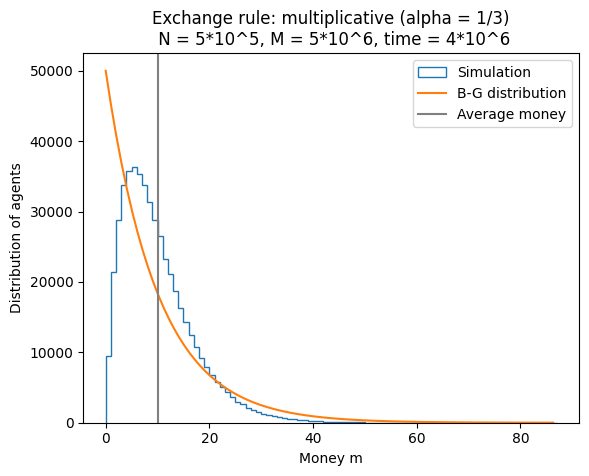

In [10]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.axvline(x=T, color = 'gray', label='Average money')
plt.title(f"Exchange rule: {exchange_rule} (alpha = 1/3)\n N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

Podemos observar que la distribución estacionaria tiene una forma diferente a la distribución B-G: todavía tiene un extremo exponencial en el extremo superior, pero cae a cero en el extremo inferior. Esto último se cumple para simulaciones con $\alpha < 1/2$. Por otra parte, si realizamos una simulación de intercambio aleatorio multiplicativo con $\alpha = 1/2$, tenemos que

In [11]:
alpha = 1/2
# Se crean a los agentes
agents_list = [Agent_multiplicative(money=T, alpha=alpha) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index])

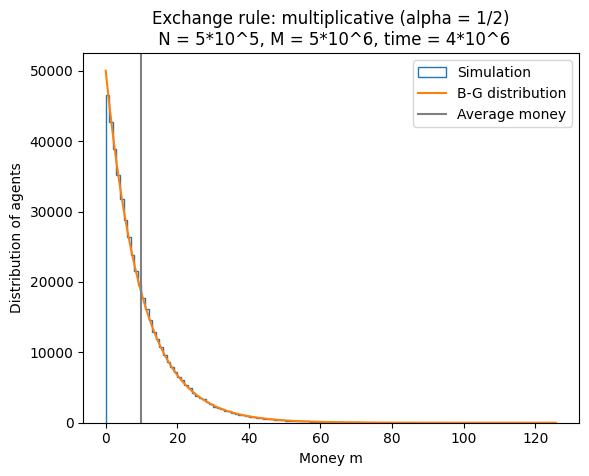

In [12]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.axvline(x=T, color = 'gray', label='Average money')
plt.title(f"Exchange rule: {exchange_rule} (alpha = 1/2)\n N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

### Modelo de intercambio aleatorio con impuestos y subsidios: Simulaciones

Otro ejemplo interesante cuya distribución no es de B-G ocurre en un modelo con impuestos y subsidios. Supóngase que un agente especial ("gobierno") recolecta una fracción $f$ ("impuesto") de toda transacción en el sistema, de tal manera que cada agente recibe un subsidio $\delta m$ con una frecuencia $1/\tau_s$.

A continuación se muestran los resultados de una simulación. Los parámetros son: $f = 0.40$, $\tau_s = 4000$, $N = 5 \times 10^{4}$ y $M = 5 \times 10^{5}$. Por lo tanto, al principio de las simulaciones, los agentes cuentan con la misma cantidad de dinero $\left\langle m \right\rangle = \frac{M}{N} = 10$.

In [21]:
from economic_agent import Agent_citizen, State
from random import randint
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Parámetros
Nexp = 4
N = int(5*10**Nexp) # número de agentes

Mexp = 5
M = 5*10**Mexp # cantidad total de dinero en el sistema

T = M/N # temperatura de dinero

# reglas de intercambio
exchange_rules = ['small_constant', 'random_pair_average', 'random_system_average']
ex_order = 3 # Regla
exchange_rule = exchange_rules[ex_order - 1]

tax_rate = 0.40 # 0.10

texp = 6 # Se recomienda 5
t_steps = int(4*10**texp) # Pasos de tiempo para la simulación
tau_s = 4000 # Período de subsidios

In [23]:
# Se crean a los agentes
agents_list = [Agent_citizen(money=T) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
government = State(tax_rate=tax_rate)
# Simulación
for i in range(1,t_steps+1):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index], transaction_type=exchange_rule, system_avg=T, mediator=government)
    #Subsidio
    if i%tau_s == 0:
        government.subsidize(to_agents=agents_list)

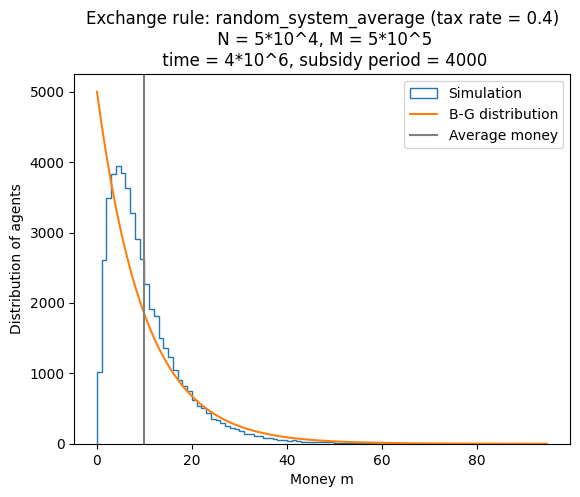

In [24]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.axvline(x=T, color = 'gray', label='Average money')
plt.title(f"Exchange rule: {exchange_rule} (tax rate = {tax_rate})\n N = 5*10^{Nexp}, M = 5*10^{Mexp}\n time = 4*10^{texp}, subsidy period = {tau_s}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

Se puede observar que la distribución estacionaria es una distribución B-G desplazada. La población con bajos niveles económicos se ve disminuída porque el gobierno, actuando como una fuerza externa, “expulsa” a esa población y empuja al sistema fuera del equilibrio termodinámico.

Estos ejemplos muestran que la distribución de Boltzmann-Gibbs no es completamente universal, es decir, no se cumple para cualquier modelo de intercambio que conserve dinero. Sin embargo, es universal en un sentido limitado: para una amplia clase de modelos que tienen simetría de inversión temporal, la distribución estacionaria es exponencial y no depende de los detalles de un modelo. Por el contrario, cuando se rompe la simetría de inversión temporal, la distribución puede depender de los detalles del modelo. La diferencia entre estas dos clases de modelos puede ser bastante sutil.

A diferencia de lo que ocurre en la física, en economía no existe un requisito fundamental de que las interacciones tengan simetría de inversión temporal. Sin embargo, en ausencia de un conocimiento detallado de la dinámica microscópica real del intercambio económico, la distribución semiuniversal de Boltzmann-Gibbs parece ser un punto de partida natural.

## Modelos con deuda

Ahora analicemos qué sucede si se permite a los agentes endeudarse. La deuda puede considerarse como dinero negativo. Ahora bien, cuando un perdedor no tiene suficiente dinero para pagar, puede pedir prestada la cantidad necesaria a un depósito o "reservorio", y su saldo se vuelve negativo. No se viola la ley de conservación: la suma del dinero positivo del ganador y el dinero negativo del perdedor permanece constante. Cuando un agente con un saldo negativo recibe dinero como ganador, utiliza este dinero para pagar la deuda hasta que su saldo se vuelve positivo. 

Suponemos, para simplificar, que el "reservorio" no cobra intereses por el dinero prestado. Sin embargo, como no es sensato permitir una deuda ilimitada, ponemos un límite $m_d$ a la deuda máxima de un agente: $m_{i} > -m_{d}$. Esta nueva condición a la frontera $P\left( m < -m_{d} \right) = 0$ reemplaza a la vieja condición $P\left( m < 0 \right) = 0$. De nuevo $P\left( m \right)$ está dada por la ley de Boltzmann-Gibbs, 

$$
P\left( m  \right) = \frac{1}{T}\exp \left[ -\left( m+m_d \right)/T \right]
$$ 

(así se cumple la condición de normalización $\int_{-m_d}^{\infty }P\left( m  \right) dm = 1$), pero ahora,

$$
\left\langle m \right\rangle = \int_{-m_d}^{\infty }m P\left( m  \right) dm = T-m_{d}
$$

por lo que ahora se tiene una temperatura de dinero $T = M/N + m_{d}$ más alta.

### Descripción del modelo

Los agentes económicos interaccionan a pares mediante transacciones monetarias. Solo se puede recibir o dar dinero en las transacciones.

Sean $i$ ("perdedor") y $j$ ("ganador") un par de agentes económicos que interaccionan. Sean $m$ y $m'$ la cantidad de dinero que posee un agente, antes y después de la transacción, la cual se da según

$$
m_i \longrightarrow m'_i = m_i - \Delta m \\
m_j \longrightarrow m'_j = m_j + \Delta m
$$

donde $\Delta m$ es el dinero que el "perdedor" transfirió al "ganador" después de la transacción.

Suposiciones y restricciones:

* El dinero se conserva, global y localmente, $m_i + m_j = m'_i + m'_j$
* El balance de los ganadores no puede ser menor a la deuda máxima, $m_i \ge -m_{d} \forall i$
* Una transacción se da solamente cuando el agente "perdedor" tiene el suficiente dinero para pagar, $m_{i} \ge \Delta m - m_{d}$

### Cómo se realizan las simulaciones

Los pasos para realizar una simulación son los siguientes:
* Inicialmente todos los agentes tienen la misma cantidad de dinero.
* Se elige un par ($i,j$) de agentes al azar, y se realiza la transacción, es decir, se transfiere la cantidad $\Delta m$.
* Se repite el paso anterior muchas veces.

En este trabajo se realizan simulaciones con cada una de las siguientes reglas de intercambio:
* Regla 1: Intercambio de una pequeña cantidad constante, $\Delta m = 1$.
* Regla 2: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del par, $\Delta m = \nu \left[ \left( m_i + m_j \right)/2 + m_d \right] $
* Regla 3: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del sistema,  $\Delta m = \nu M/N$

Nótese que el modelo anterior se generaliza al modelo con deuda si hacemos el cambio de variable $m \longrightarrow m + m_{d}$.

### Simulaciones

In [1]:
from economic_agent import Agent_debtor
from random import randint
import matplotlib.pyplot as plt
import numpy as np

Los parámetros para las simulaciones son: $N = 5 \times 10^{4}$ y $M = 5 \times 10^{5}$. Por lo tanto, al principio de las simulaciones, los agentes contarán con la misma cantidad de dinero $\left\langle m \right\rangle = \frac{M}{N} = 10$.

In [2]:
# Parámetros
Nexp = 4
N = int(5*(10**Nexp)) # número de agentes

Mexp = 5
M = 5*10**Mexp # cantidad total de dinero en el sistema

m_avg = M/N # Cantidad promedio de dinero en el sistema

Primero realicemos una simulación para deuda máxima $m_d = 8$. La temperatura de dinero del sistema de agentes sera, por lo tanto, $T = M/N + m_d = 18$.

In [3]:
m_d = 8
T = m_avg + m_d # temperatura de dinero

texp = 5
t_steps = int(4*(10**texp)) # Pasos de tiempo de la simulación
# regla de intercambio
exchange_rules = ['small_constant', 'random_pair_average', 'random_system_average']
ex_order = 2
exchange_rule = exchange_rules[ex_order - 1]

# Creamos a los agentes
agents_list = [Agent_debtor(money=m_avg, maximum_debt=m_d) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]

    agents_list[loser_index].pay(agents_list[winner_index], transaction_type=exchange_rule, system_avg=m_avg)

In [4]:
# Datos para el histograma
m_arr_a = np.array([agent.money for agent in agents_list])
nb_bins_a = int(max(m_arr_a)) + m_d
frq_a,edges_a = np.histogram(m_arr_a, bins=nb_bins_a)

# Distribución de Boltzmann-Gibbs
m_a = np.linspace(-m_d,max(m_arr_a), nb_bins_a)
P_a = N*(1/T)*np.exp(-(m_a+m_d)/T)

T_a,texp_a,m_d_a = T,texp,m_d

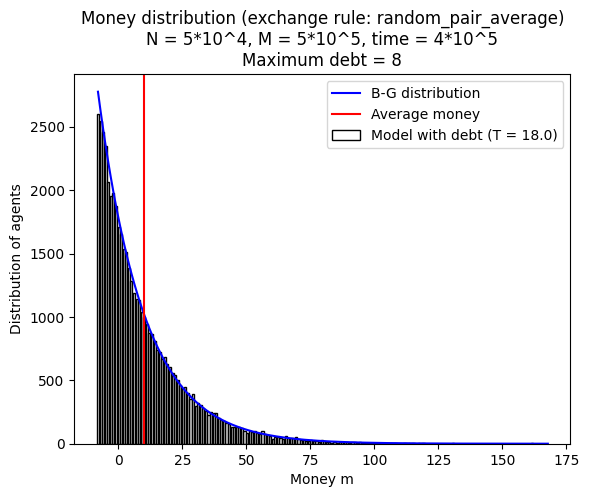

In [5]:
plt.bar(edges_a[:-1], frq_a, fill=False ,label=f"Model with debt (T = {T_a})")
plt.plot(m_a, P_a, label="B-G distribution", color='blue')
plt.axvline(x=m_avg, color = 'red', label='Average money')
ttl = ""
ttl += f"Money distribution (exchange rule: {exchange_rule})\n"
ttl += f"N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp_a}\n"
ttl += f"Maximum debt = {m_d_a}"
plt.title(ttl)
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")

plt.legend()
plt.show()

A continuación realizamos una simulación sin deuda, $m_d = 0$, para comparar. La temperatura de dinero del sistema de agentes sera, por lo tanto, $T = M/N + m_d = 10$.

In [6]:
m_d = 0
T = m_avg + m_d # temperatura de dinero

texp = 5
t_steps = int(4*(10**texp)) # Pasos de tiempo de la simulación
# regla de intercambio
exchange_rules = ['small_constant', 'random_pair_average', 'random_system_average']
ex_order = 2
exchange_rule = exchange_rules[ex_order - 1]

# Creamos a los agentes
agents_list = [Agent_debtor(money=m_avg, maximum_debt=m_d) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]

    agents_list[loser_index].pay(agents_list[winner_index], transaction_type=exchange_rule, system_avg=m_avg)

In [7]:
# Datos para el histograma
m_arr_b = np.array([agent.money for agent in agents_list])
nb_bins_b = int(max(m_arr_b)) + m_d
frq_b,edges_b = np.histogram(m_arr_b, bins=nb_bins_b)

# Distribución de Boltzmann-Gibbs
m_b = np.linspace(-m_d,max(m_arr_b), nb_bins_b)
P_b = N*(1/T)*np.exp(-(m_b+m_d)/T)

T_b,texp_b,m_d_b = T,texp,m_d

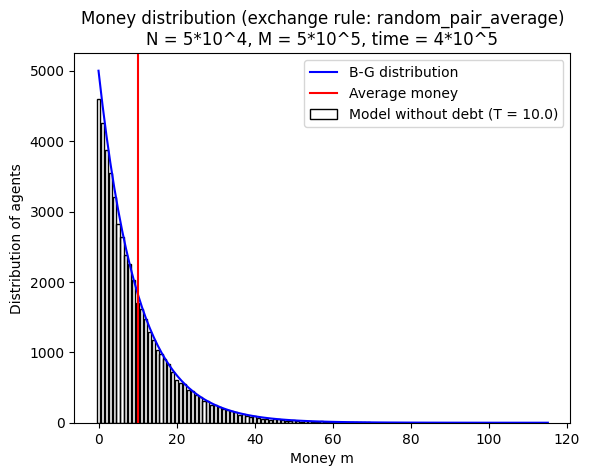

In [8]:
plt.bar(edges_b[:-1], frq_b, fill=False ,label=f"Model without debt (T = {T_b})")
plt.plot(m_b, P_b, label="B-G distribution", color='blue')
plt.axvline(x=m_avg, color = 'red', label="Average money")
ttl = ""
ttl += f"Money distribution (exchange rule: {exchange_rule})\n"
ttl += f"N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp_b}"
plt.title(ttl)
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")

plt.legend()
plt.show()

Por último, si comparamos las distribuciones B-G para ambos casos,

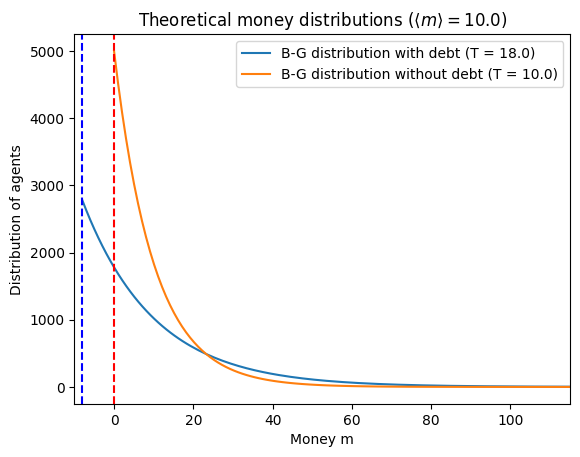

In [9]:
plt.plot(m_a, P_a, label=f"B-G distribution with debt (T = {T_a})")
plt.axvline(x = -m_d_a, color = 'blue', ls='--')
plt.plot(m_b, P_b, label=f"B-G distribution without debt (T = {T_b})")
plt.axvline(x = -m_d_b, color = 'red', ls='--')

ttl = r"Theoretical money distributions ($\left\langle m \right\rangle =$"
ttl += f"{m_avg})"
plt.title(ttl)

plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
plt.xlim(-(m_d_a+2), max(m_b))
plt.legend()
plt.show()

Citando el artículo, 

> vemos que la temperatura más alta hace que la distribución del dinero sea más amplia, lo que significa que la deuda aumenta la desigualdad entre los agentes.

Para probar o refutar este enunciado, vamos a calcular el coeficiente Gini, es decir, el grado de desigualdad presente en la distribución de dinero B-G con deuda.

El coeficiente Gini de una distribución $P\left( m \right)$ se define en referencia a la curva de Lorentz, la cual se define como

$$
L\left( F\left( m \right) \right) = \frac{1}{\left\langle m \right\rangle}\int_{m_{min}}^{m}m'P\left( m' \right)dm'
$$

donde $F\left( m \right) = \int_{m_{min}}^{m}P\left( m' \right)dm'$ es la distribución acumulada de $P\left( m \right)$ y $\left\langle m \right\rangle = \int_{m_{min}}^{\infty} m' P\left( m' \right)dm'$ es la media de $P\left( m \right)$. Intuitivamente, esta integral representa la parte de algún activo que está en manos de la parte $100F$% inferior de la población. El coeficiente de Gini se obtiene entonces mediante el doble de la diferencia entre el área bajo la curva de Lorenz de una distribución perfectamente igualitaria (una línea recta con una pendiente de 1) y la curva de Lorenz de la distribución en cuestión,

$$
G = 1-2\int_{0}^{1}L\left( F \right)dF
$$

En el caso particular de la distribución B-G con deuda tenemos que $m_{min} = -m_{d}$, por lo que $F\left( m \right) = \int_{-m_{d}}^{m}\frac{1}{T}\exp \left[ -\left( m'+m_d \right)/T \right]dm' = 1 - \exp\left( -\frac{m+m_d}{T} \right) = 1 - \exp\left( -\frac{m+m_d}{\left\langle m \right\rangle+m_d} \right)$, y 

$$
L = \frac{1}{\left\langle m \right\rangle}\int_{-m_d}^{m}m'\frac{1}{T}\exp \left[ -\left( m'+m_{d} \right)/T \right]dm' = \frac{\left\langle m \right\rangle-\left( m + T \right)\exp \left[ -\left( m+m_{d} \right)/T \right]}{\left\langle m \right\rangle} \\
= \frac{\left\langle m \right\rangle-\left( m+T \right)\left( 1-F \right)}{\left\langle m \right\rangle} = \frac{\left\langle m \right\rangle- \left[ T \ln \frac{1}{1-F}-m_{d}+T \right] \left( 1-F \right)}{\left\langle m \right\rangle} \\
= \frac{\left\langle m \right\rangle - \left[ T \ln \frac{1}{1-F} + \left\langle m \right\rangle \right] \left( 1-F \right)}{\left\langle m \right\rangle} = 1 - \left( 1-F \right)\left( 1+ \frac{\left\langle m \right\rangle + m_d}{\left\langle m \right\rangle} \ln \frac{1}{1-F} \right)
$$

Grafiquemos la curvas de Lorentz correspondientes a las distribuciones teóricas,

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Nexp = 4
N = int(5*(10**Nexp)) # número de agentes

Mexp = 5
M = 5*10**Mexp # cantidad total de dinero en el sistema

m_avg = M/N

F = np.linspace(0.0,0.99,50)

m_d_a = 8 # Deuda máxima
T_a = m_avg + m_d_a # Temperatura de dinero
L_a = np.log(1/(1-F))
L_a *= (m_avg+m_d_a)
L_a /= m_avg
L_a += 1
L_a *= (F-1)
L_a += 1.0

m_d_b = 0 # Deuda máxima
T_b = m_avg + m_d_b # Temperatura de dinero
L_b = np.log(1/(1-F))
L_b *= (m_avg+m_d_b)
L_b /= m_avg
L_b += 1
L_b *= (F-1)
L_b += 1.0

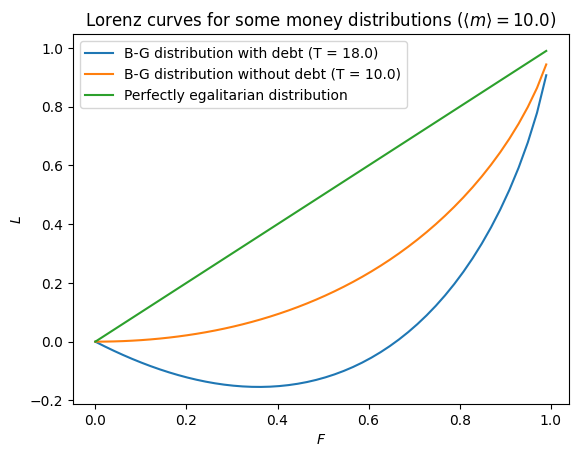

In [4]:
plt.plot(F, L_a, label=f"B-G distribution with debt (T = {T_a})")
plt.plot(F, L_b, label=f"B-G distribution without debt (T = {T_b})")
plt.plot(F,F, label="Perfectly egalitarian distribution")
ttl = r"Lorenz curves for some money distributions ($\left\langle m \right\rangle =$"
ttl += f"{m_avg})"
plt.title(ttl)
plt.xlabel(r"$F$")
plt.ylabel(r"$L$")

plt.legend()
plt.show()

En esta figura se observa que la distribución con deuda se aleja más de la distribución igualitaria que la distribución sin deuda. Por último, al introducir la última expresión para $L\left( F \right)$ en la fórmula del coeficiente de Gini e integrar, se obtiene que el coeficiente de Gini de la distribución de dinero B-G con deuda máxima $m_d$ es igual a 

$$
G = 1 - \frac{\left\langle m \right\rangle-m_d}{2\left\langle m \right\rangle} = \frac{1+m_{d}/\left\langle m \right\rangle}{2}
$$

Por lo tanto, en distribuciones de dinero B-G con deuda, a mayor deuda máxima, mayor desigualdad. O lo que es lo mismo, "la deuda aumenta la desigualdad entre los agentes".

## Un modelo más realista

Para que el modelo sea un poco más realista, introducimos empresas. Un agente a la vez se convierte en una empresa. La empresa toma prestado capital $K$ de otro agente y lo devuelve con un interés $rK$, contrata $L$ agentes y les paga un salario $W$, fabrica $Q$ artículos de un producto y los vende a $Q$ agentes a un precio $R$. Todos estos agentes son seleccionados aleatoriamente. La empresa recibe la ganancia
$$
F = RQ - LW - rK
$$

El resultado neto es un intercambio de dinero entre muchos cuerpos que aún satisface la ley de conservación.

Los parámetros del modelo que maximizan la ganancia se obtienen de la siguiente forma:

1) Se establece la curva de oferta-demanda agregada, $R\left( Q \right) = V/Q^{\eta}$, donde $Q$ es la cantidad de productos que la gente compraría a un precio $R$. $V = 100$ y $\eta = 1/2$ son constantes.
2) Se establece la función de producción de la firma, $Q\left( L,K \right) = L^{\beta}K^{1-\beta}$, con $\beta = 8/10$.
3) Se sustituyen las expresiones de los pasos anteriores en la ecuación de la ganacia, y se obtiene la ecuación $F\left( L,K \right) = V Q^{1-\eta} - LW - rK = V \left(L^{\beta}K^{1-\beta}\right)^{1-\eta} - LW - rK$
4) Se resuelve $\nabla F\left( L,K \right) = 0$ para maximizar la ganancia. La solución es 
$$
L_{critico} = \left( \frac{V \beta\left( 1-\eta \right)}{W} \right)^{1/\eta}\left( \frac{W \left( 1-\beta \right)}{r\beta} \right)^{\left(1-\beta\right)\left(1-\eta\right)/\eta}\\
K_{critico} = \frac{1-\beta}{\beta}\cdot\frac{W}{r}L_{critico}
$$

Una vez se establecen los valores de los parámetros $W$ y $r$, se pueden encontrar los valores de $L_{critico}$, $K_{critico}$, $Q_{c} = Q \left( L_{critico},K_{critico}  \right)$, $R_{c} = R \left( Q_c \right)$ y $F_{max}$, en ese orden. Por ejemplo, si $W = 10$ y $r=0.15$, entonces
$$
L_{critico} = \simeq 28\\
K_{critico} = 468.1\\
Q_{c} \simeq 49\\
R_{c} = 14.242\\
F_{max} = 351.075
$$

Es decir, con aquellos valores de salario y tasa de interés, la empresa obtendrá una ganancia máxima de 351.1$ si contrata a 28 trabajadores, toma prestado 468.1$ de capital, fabrica 49 artículos de su producto y los vende a 14.2$ cada uno.

### Cómo se van a realizar las simulaciones

Los pasos para realizar una simulación son los siguientes:
1) Se establecen los parámetros $N$, $T$ y $W$. Inicialmente todos los agentes tienen la misma cantidad de dinero $T$, y de ahí $M = N T$.
2) **Préstamo**: Se selecciona un par de agentes al azar del conjunto $A = \left\{ a_i \right\}_{i=1}^{N}$. El primer agente será la empresa $e$, y el segundo será el prestamista $p$. Antes del préstamo se establece una tasa de interés $r = \nu$, donde $\nu_{min} \le \nu \le \nu_{max}$ es una variable aleatoria uniforme. Se calculan los valores de $L_{critico}$, $K_{critico}$, $Q_c$ y $R_c$, en ese orden. El agente $p$ le presta un capital $\Delta m = K$ a $e$, con $K = K_{critico}$ (si $K_{critico}$ es mayor que la cantidad de dinero $m_{p}$ que posee el agente $p$, se repite este paso hasta que se encuentre un agente $p$ que pueda prestar capital).
3) **Contratación**: Se establece el número $L$ de trabajadores a contratar de la siguiente manera. Definamos a $f_{L} \equiv L/L_{critico}$ como la fracción de trabajadores que $e$ puede contratar. Si $m_e \ge L_{critico} W$, entonces $e$ tiene dinero suficiente para contratar un número de trabajadores que le permita maximizar su ganancia, por lo que $f_{L} = 1$ y $L = L_{critico}$; de lo contrario, $f_{L} = \frac{m_e}{L_{critico} W}$, y $L = f_{L} L_{critico} = m_{e}/W$.
4) **Producción**: Se seleccionan $L$ trabajadores al azar del conjunto $B = A - \left\{ e,p \right\}$. Estos trabajadores producen $Q = f_{L} Q_{c}$ artículos y se les paga el salario $\Delta m = W$ a cada uno de ellos por parte de $e$.
5) **Venta**: Se selecciona a $Q$ compradores al azar del conjunto $B$. A cada uno de estos compradores se le vende un artículo por parte de $e$ al precio $\Delta m = R_c$.
6) **Devolución**: El agente $e$ devuelve a $p$ la cantidad $\Delta m = \left( 1+r \right)K$ por los intereses.
7) Los pasos 2, 3, 4, 5 y 6 se llevan a cabo muchas veces.

### Simulaciones

Los parámetros para las simulaciones son: $N = 5 \times 10^{3}$, $T = 500$ y $W = 10$. Por lo tanto el dinero total en el sistema será $M = N T = 2.5 \times 10^{6}$. El rango para la tasa de interés será de $0.15 \le \nu \le 0.20$.

In [1]:
from economic_agent import CapitalistAgent_02
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Paso 1 (parametros)
Nexp = 3
N = int(5*(10**Nexp)) # número de agentes

T = 500 # Temperatura de dinero
W = 10 # Salario
M = N*T # cantidad total de dinero en el sistema
interest_range = (0.15,0.20)

In [ ]:
texp = 4
t_steps = int(4*(10**texp)) # Pasos de tiempo para la simulación
# Se crean a los agentes
agents_list = np.array([CapitalistAgent_02(money=T) for i in range(N)]) # Todos los agentes tienen la misma cantidad de dinero
A_idx = range(N)
# Simulación
for i in range(t_steps):
    # Paso 2 (Préstamo)
    pair = np.random.choice(A_idx, size=2, replace=False)
    e_idx,p_idx = pair[0],pair[1]
    is_loan_taken = agents_list[e_idx].take_loan(from_agent=p_idx, W=W, interest_range=interest_range, agents_list=agents_list)

    if not is_loan_taken:
        continue

    # Paso 3 (Contratación)
    B_idx = np.array([a for a in A_idx if a not in [e_idx,p_idx]])
    f_L = agents_list[e_idx].hired_fraction(W=W)
    workers_idx = np.random.choice(B_idx, size=agents_list[e_idx].L, replace=False)
    # Paso 4 (Producción)
    agents_list[e_idx].produce(with_workers=workers_idx, fraction=f_L, wage=W, agents_list=agents_list)
    # Paso 5 (Venta)
    buyers_idx = np.random.choice(B_idx, size=agents_list[e_idx].Q, replace=False)
    agents_list[e_idx].sells(to_buyers=buyers_idx, agents_list=agents_list)
    # Paso 6 (Devolución)
    agents_list[e_idx].return_loan(to_agent=p_idx, agents_list=agents_list)

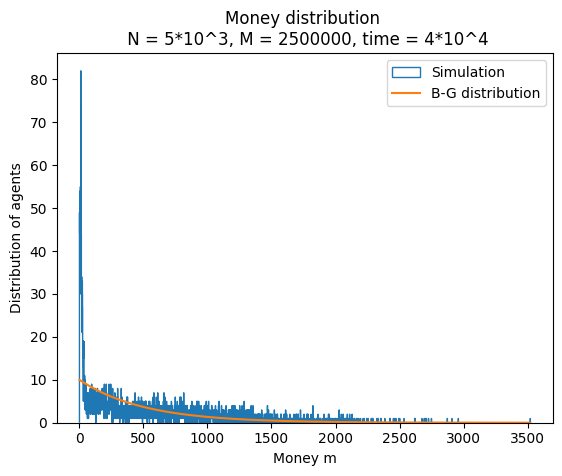

In [4]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step', density=False)
plt.plot(m_values, P_values, label="B-G distribution")
plt.title(f"Money distribution \n N = 5*10^{Nexp}, M = {M}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

En la siguiente simulación obtenemos histogramas para los siguientes indicadores:
* Dinero
* Número de veces que un agente se vuelve empresario
* Número de veces que un agente se vuelve prestamista
* Número de veces que un agente se vuelve trabajador
* Número de veces que un agente se vuelve comprador

Parámetros: $N = 10^{4}$, $T = 500$, $W = 10$, $M = N T = 5 \times 10^{6}$, $0.15 \le \nu \le 0.20$.

In [5]:
from economic_agent import CapitalistAgent_03
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#Paso 1 (parametros)
Nexp = 4
N = int(2*10**Nexp) # número de agentes

T = 500 # esta cantidad garantiza que todos los agentes puedan ser prestamistas al inicio
W = 10 # Salario
M = N*T # cantidad total de dinero en el sistema
interest_range = (0.15,0.20)

In [7]:
texp = 5
t_steps = int(10**texp) # Pasos de tiempo para la simulación

# Se crean a los agentes
agents_list = np.array([CapitalistAgent_03(money=T) for i in range(N)])
A_idx = range(N)
# Simulación
for i in range(t_steps):
    #Paso 2 (Préstamo)
    pair = np.random.choice(A_idx, size=2, replace=False)
    e_idx,p_idx = pair[0],pair[1]
    is_loan_taken = agents_list[e_idx].take_loan(from_agent=p_idx, W=W, interest_range=interest_range, agents_list=agents_list)

    if not is_loan_taken:
        continue

    #Paso 3 (Contratacion)
    B_idx = np.array([a for a in A_idx if a not in [e_idx,p_idx]])
    f_L = agents_list[e_idx].hired_fraction(W=W)
    workers_idx = np.random.choice(B_idx, size=agents_list[e_idx].L, replace=False)
    #Paso 4 (Producción)
    agents_list[e_idx].produce(with_workers=workers_idx, fraction=f_L, wage=W, agents_list=agents_list)
    #Paso 5 (Venta)
    buyers_idx = np.random.choice(B_idx, size=agents_list[e_idx].Q, replace=False)
    agents_list[e_idx].sells(to_buyers=buyers_idx, agents_list=agents_list)
    #Paso 6 (Devolución)
    agents_list[e_idx].return_loan(to_agent=p_idx, agents_list=agents_list)

In [8]:
# Datos para los histogramas
final_m_array = np.array([agent.money for agent in agents_list])
nb_m_bins = int(max(final_m_array))
final_e_array = np.array([agent.e for agent in agents_list])
nb_e_bins = int(max(final_e_array))
final_p_array = np.array([agent.p for agent in agents_list])
nb_p_bins = int(max(final_p_array))
final_w_array = np.array([agent.w for agent in agents_list])
nb_w_bins = int(max(final_w_array))
final_pu_array = np.array([agent.pu for agent in agents_list])
nb_pu_bins = int(max(final_pu_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_m_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

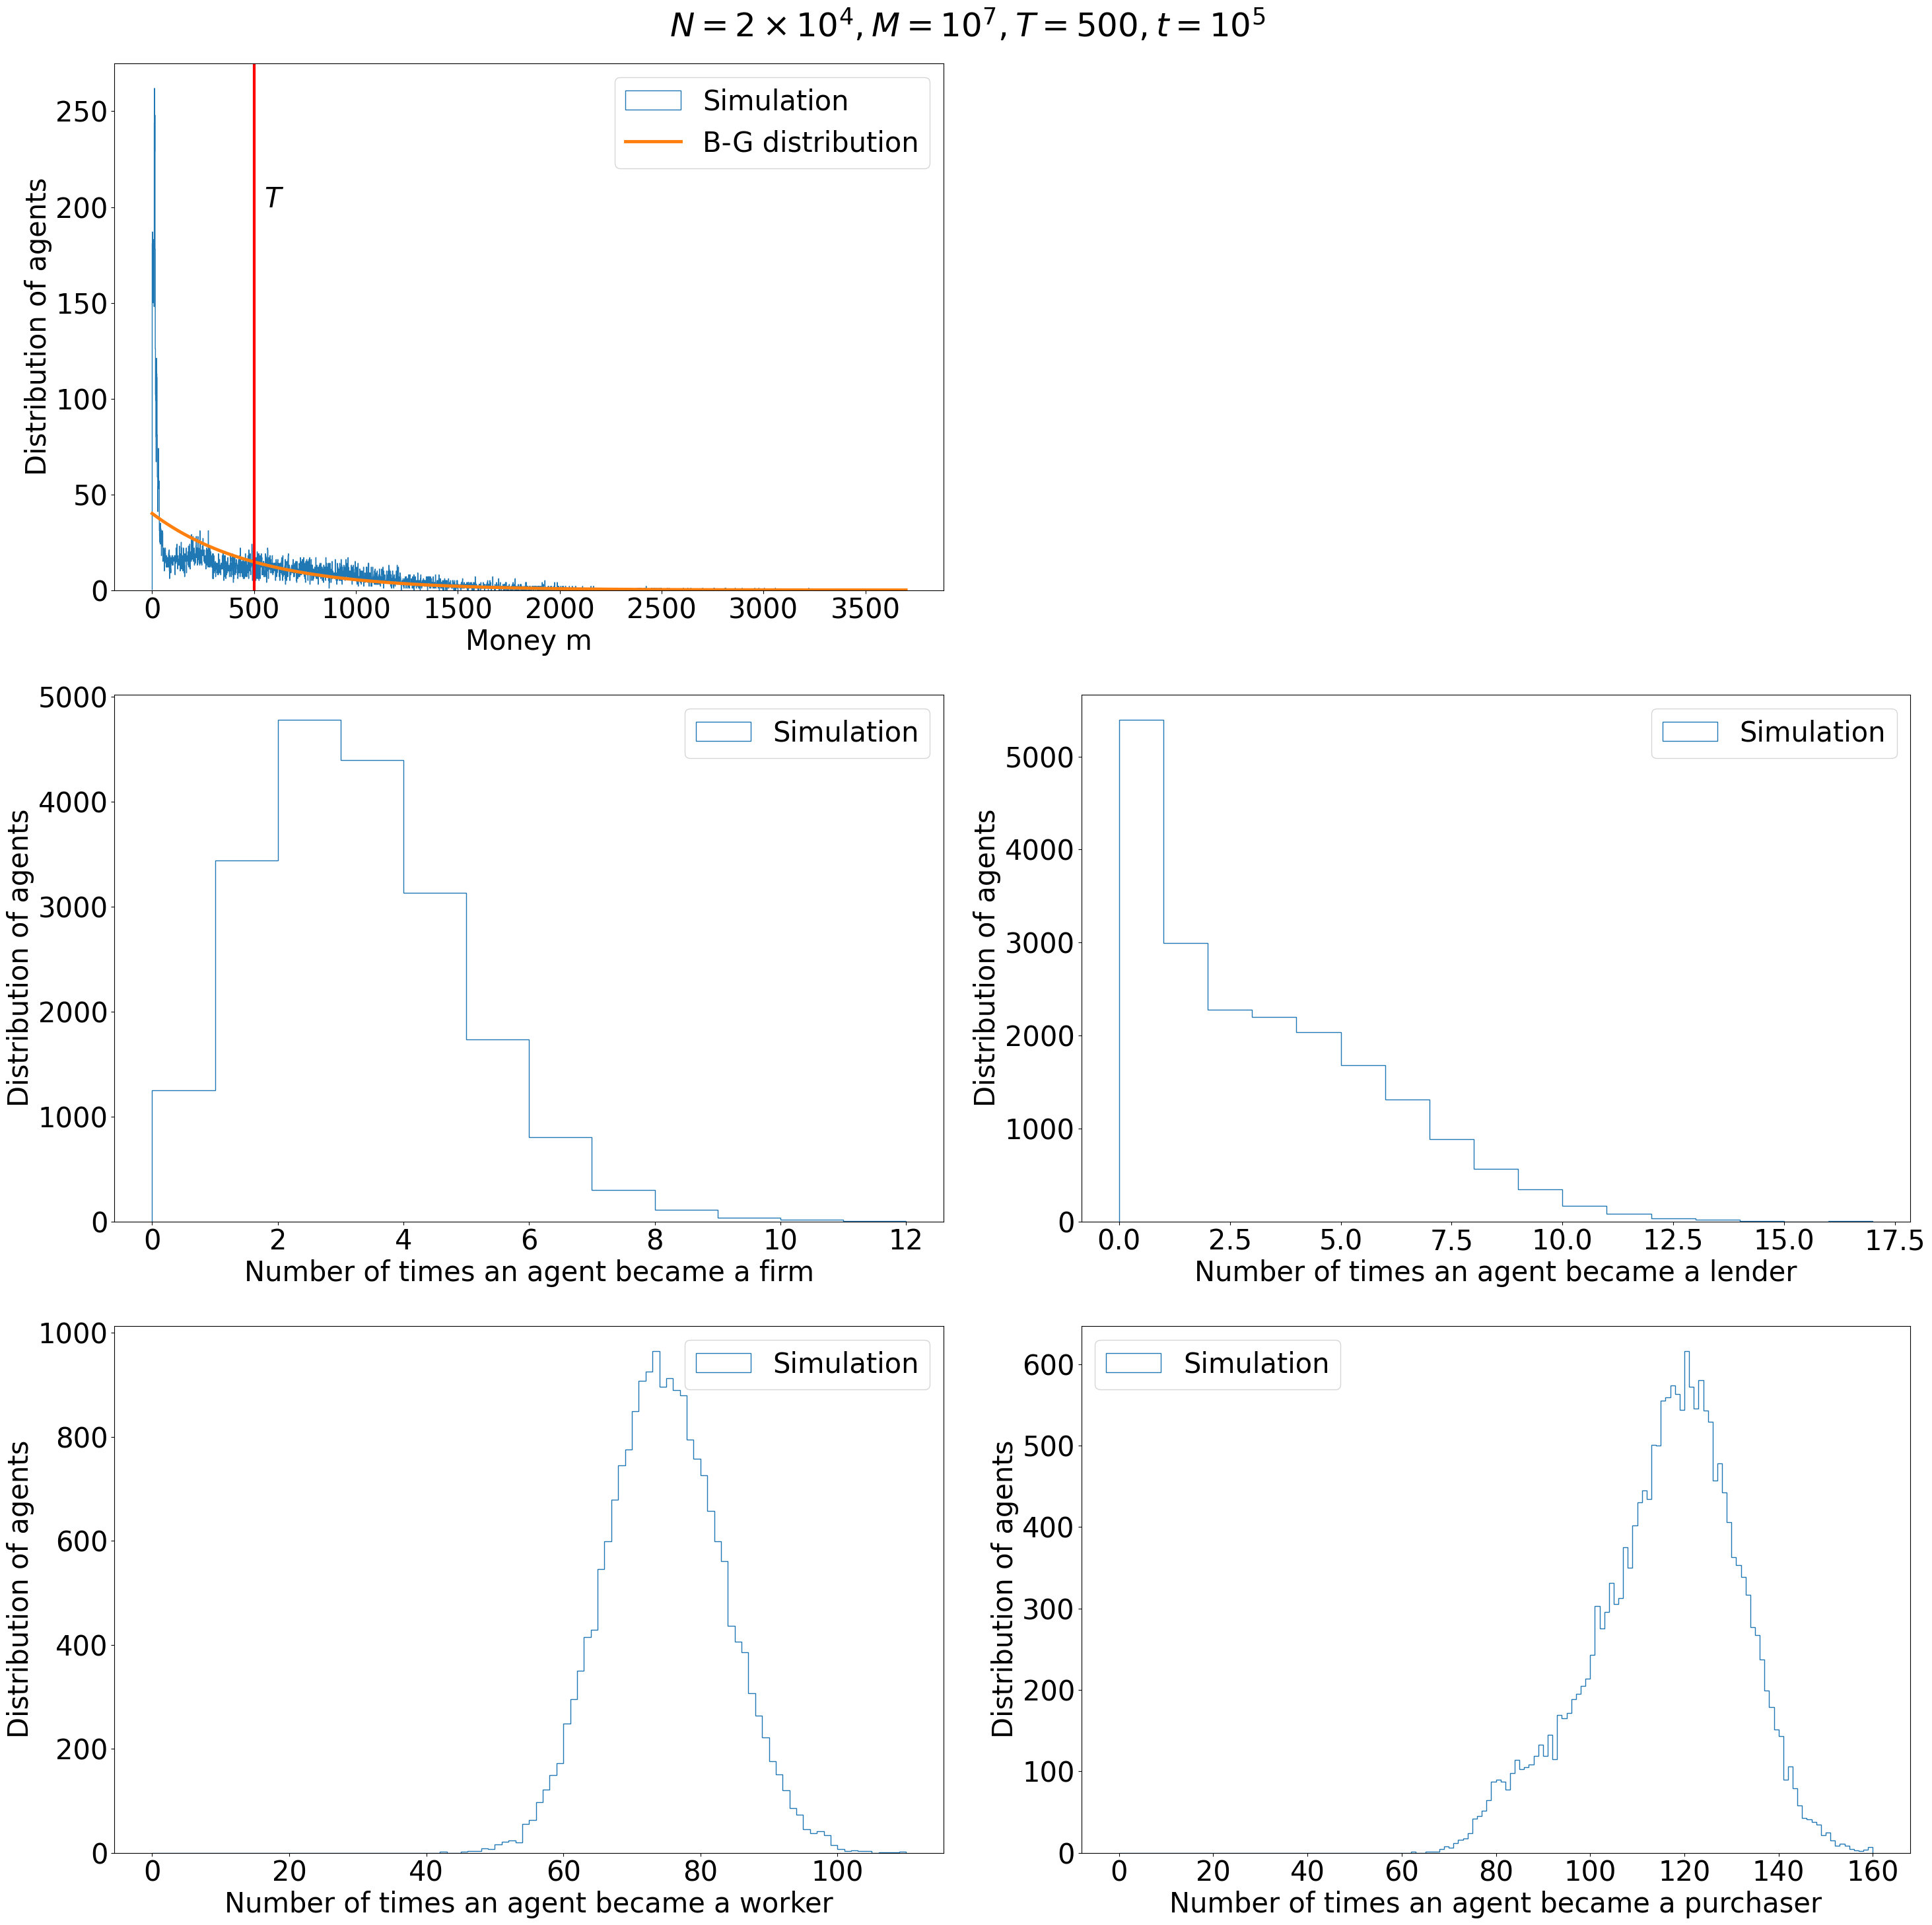

In [9]:
plt.rcParams.update({'font.size': 30})

fig,ax = plt.subplots(3,2,figsize=(30,30))

fig.suptitle(r"$N = 2 \times 10^{4}, M = 10^{7}, T = 500, t = 10^{5}$")

ax[0,0].hist(final_m_array, bins=range(nb_m_bins+1), label="Simulation", histtype='step', density=False)
ax[0,0].plot(m_values, P_values, label="B-G distribution", linewidth=3.5)
ax[0,0].set_xlabel("Money m")
ax[0,0].set_ylabel("Distribution of agents")
#ax[0,0].axvline(x = T, color = 'r', label = 'Money temperature', linewidth=3.0)
ax[0,0].axvline(x = T, color = 'r', linewidth=3.0)
ax[0,0].legend()
#ax[0,0].set_ylim(0,60)
ax[0,0].text(T+50,200,r"$T$")

fig.delaxes(ax[0,1])

ax[1,0].hist(final_e_array, bins=range(nb_e_bins+1), label="Simulation", histtype='step', density=False)
ax[1,0].set_xlabel("Number of times an agent became a firm")
ax[1,0].set_ylabel("Distribution of agents")
ax[1,0].legend()

ax[1,1].hist(final_p_array, bins=range(nb_p_bins+1), label="Simulation", histtype='step', density=False)
ax[1,1].set_xlabel("Number of times an agent became a lender")
ax[1,1].set_ylabel("Distribution of agents")
ax[1,1].legend()

ax[2,0].hist(final_w_array, bins=range(nb_w_bins+1), label="Simulation", histtype='step', density=False)
ax[2,0].set_xlabel("Number of times an agent became a worker")
ax[2,0].set_ylabel("Distribution of agents")
ax[2,0].legend()

ax[2,1].hist(final_pu_array, bins=range(nb_pu_bins+1), label="Simulation", histtype='step', density=False)
ax[2,1].set_xlabel("Number of times an agent became a purchaser")
ax[2,1].set_ylabel("Distribution of agents")
ax[2,1].legend()

plt.tight_layout()
#path = f"Realistic_extra_texp={texp}.png"
#plt.savefig(path)
plt.show()